# Fake news prediction model

## Dependencies

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from tqdm import tqdm

## Data processing

### Loading the cleaned data

In [6]:
chunk_size = 1000
rows = 868346
chunks = []

# * Load csv file with tqdm for tracking progress
with tqdm(desc="Loading csv file", total=rows) as pbar:
    for chunk in pd.read_csv("1.000.000 cleaned/data_cleaned_fr.csv", chunksize=chunk_size):
        chunks.append(chunk)
        pbar.update(len(chunk))

df = pd.concat(chunks)

Loading csv file: 100%|██████████| 868346/868346 [00:18<00:00, 48201.94it/s]


### Distribution

In [7]:
print(f'Total article amount: {len(df['type'])}')
print(f'Fake article amount: {len(df[df['type']=='fake'])}')
print(f'Reliable article amount: {len(df[df['type']=='reliable'])}')
print(f'Reliable percentage: {(len(df[df['type']=='reliable'])/len(df['type'])*100):.2f}%')

Total article amount: 868346
Fake article amount: 294621
Reliable article amount: 573725
Reliable percentage: 66.07%


### Splitting

In [8]:
X = df['content']
y = df['type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Vectorization

In [104]:
vectorizer = TfidfVectorizer(max_features=100000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

print("Original training class distribution:")
print(y_train.value_counts())
print("Test class distribution:")
print(y_test.value_counts())

Original training class distribution:
type
reliable    458979
fake        235697
Name: count, dtype: int64
Test class distribution:
type
reliable    114746
fake         58924
Name: count, dtype: int64


### Over sampling

In [105]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vectorized, y_train)
print("Resampled training class distribution:")
print(pd.Series(y_train_resampled).value_counts())

Resampled training class distribution:
type
reliable    458979
fake        458979
Name: count, dtype: int64


## Training and evaluation

### Model training

In [107]:
classifier = MLPClassifier(
    solver='adam',
    alpha=1e-4,
    hidden_layer_sizes=(50, 50, 50),
    shuffle=False,
    random_state=42,
    tol=0.0001,
    verbose=True,
    max_iter=50,
    batch_size=1024,
    learning_rate='adaptive',
    n_iter_no_change=4
)
classifier.fit(X_train_resampled, y_train_resampled)

Iteration 1, loss = 0.21091826
Iteration 2, loss = 0.19983332
Iteration 3, loss = 0.15051730
Iteration 4, loss = 0.11591773
Iteration 5, loss = 0.08668380
Iteration 6, loss = 0.05976950
Iteration 7, loss = 0.04254922
Iteration 8, loss = 0.03312973
Iteration 9, loss = 0.03112516
Iteration 10, loss = 0.02768854
Iteration 11, loss = 0.02149680
Iteration 12, loss = 0.01773085
Iteration 13, loss = 0.01573440
Iteration 14, loss = 0.01491887
Iteration 15, loss = 0.01380041
Iteration 16, loss = 0.01270064
Iteration 17, loss = 0.01154453
Iteration 18, loss = 0.01219706
Iteration 19, loss = 0.00774687
Iteration 20, loss = 0.00687735
Iteration 21, loss = 0.00677121
Iteration 22, loss = 0.00636524
Iteration 23, loss = 0.00646725
Iteration 24, loss = 0.00652546
Iteration 25, loss = 0.00628777
Iteration 26, loss = 0.00581380
Iteration 27, loss = 0.00583752
Iteration 28, loss = 0.00574632
Iteration 29, loss = 0.00534364
Iteration 30, loss = 0.00486073
Iteration 31, loss = 0.00484895
Iteration 32, los

MLPClassifier(batch_size=1024, hidden_layer_sizes=(50, 50, 50),
              learning_rate='adaptive', max_iter=50, n_iter_no_change=4,
              random_state=42, shuffle=False, verbose=True)

### Evaluation

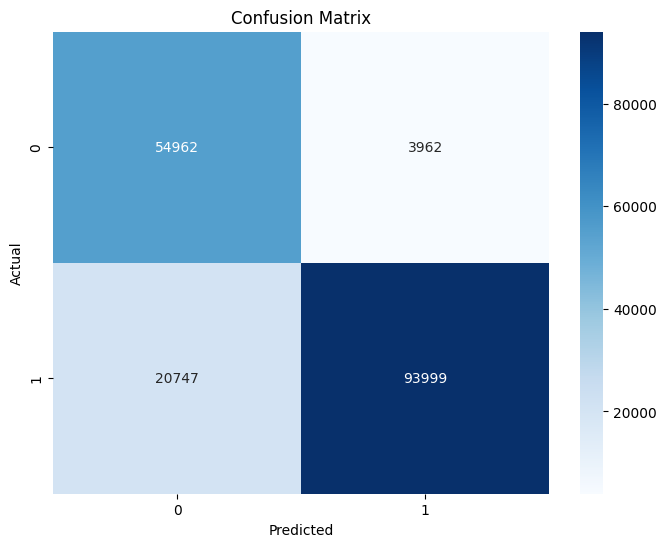

              precision    recall  f1-score   support

        fake       0.73      0.93      0.82     58924
    reliable       0.96      0.82      0.88    114746

    accuracy                           0.86    173670
   macro avg       0.84      0.88      0.85    173670
weighted avg       0.88      0.86      0.86    173670



In [109]:
y_pred = classifier.predict(X_test_vectorized)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))